In [2]:
%matplotlib inline
from skimage.feature import corner_harris
import cv2
import skimage
from skimage import data, io, draw, color, transform, filters, feature
from skimage.io import imshow
from skimage.filters import rank
import scipy
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plttc
from skimage.feature import blob_log
from skimage.color import rgb2gray

In [3]:
img1 = data.imread("Img001_diffuse_smallgray.png")
img1 = rgb2gray(img1)
img2 = data.imread("Img002_diffuse_smallgray.png")
img2 = rgb2gray(img2)
img3 = data.imread("Img009_diffuse_smallgray.png")
img3 = rgb2gray(img3)                

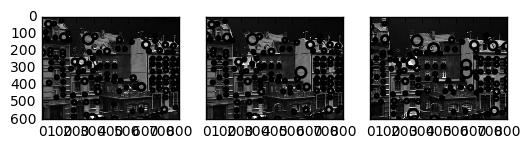

In [6]:
fig,axes = plt.subplots(1, 3, sharex=True, sharey=True, subplot_kw={'adjustable':'box-forced'})
axes = axes.ravel()

blobs = [(img, blob_log(img, threshold=0.1, min_sigma=10, max_sigma=30)) for img in [img1, img2, img3]]
    
for (img, blob) in blobs:
    ax = axes[0]
    axes = axes[1:]
    ax.set_title("")
    ax.imshow(img, interpolation='nearest',cmap='gray')
    for b in blob:
        y,x,r = b
        c = plt.Circle((x, y), r, linewidth=2, fill=False)
        ax.add_patch(c)

plt.show()

In [176]:
img1_log = scipy.ndimage.filters.gaussian_laplace(img1, sigma=6)
img2_log = scipy.ndimage.filters.gaussian_laplace(img2, sigma=6)
img3_log = scipy.ndimage.filters.gaussian_laplace(img3, sigma=6)

In [202]:
# radius = 10
import math 
from operator import itemgetter
def minZero(x):
    return max(0, x)
feature_array1 = [(x, y, img1_log[minZero(x - radius):x + radius, minZero(y - radius):y + radius]) for x, y, sigma in blobs[0][1]]
feature_array2 = [(x, y, img2_log[minZero(x - radius):x + radius, minZero(y - radius):y + radius]) for x, y, sigma in blobs[1][1]]
feature_array3 = [(x, y, img3_log[minZero(x - radius):x + radius, minZero(y - radius):y + radius]) for x, y, sigma in blobs[2][1]]

def normalize_array(a):
    x_diff = radius * 2 - a.shape[0]
    y_diff = radius * 2 - a.shape[1]
    if x_diff > 0 or y_diff > 0:
        #b = np.zeros((radius * 2, radius * 2))
        #b[int(x_diff / 2):int(radius * 2 - x_diff / 2), int(y_diff / 2):int(radius * 2 - y_diff / 2)] = a
        b =  np.lib.pad(a, [(0, x_diff), (0, y_diff)], mode = "mean")
        return b
    else:
        return a
    
def find_features(features1, features2, threshold):
    features = []
    for feature1 in features1:
        current_features = []
        for feature2 in features2:
            n1 = normalize_array(feature1[2])
            n2 = normalize_array(feature2[2])
            c1 = (feature1[0], feature1[1])
            c2 = (feature2[0], feature2[1])
            difference = math.sqrt(((n1 - n2)**2).sum())
            current_features.append((c1, c2, difference))
        sorted_features = sorted(current_features, key = lambda t: t[2])
        if sorted_features[1][2] > 0 and sorted_features[0][2] / sorted_features[1][2] <= threshold:
            features.append(sorted_features[0])
    return features
          
def match(i1, f1, i2, f2, threshold):    
    features = find_features(f1, f2, threshold)

    img1_coordinates = np.array([t[0] for t in features])
    img2_coordinates = np.array([t[1] for t in features])
    matches = np.array([(i, i) for i in range(len(features))])

    f, ax = plt.subplots()
    plt.axis('off')
    feature.plot_matches(ax, i1, i2, img1_coordinates, img2_coordinates, matches)

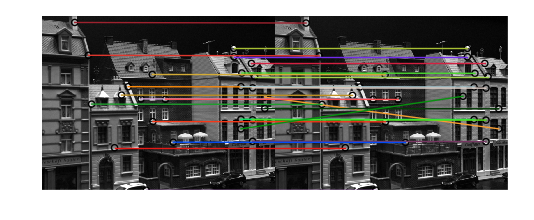

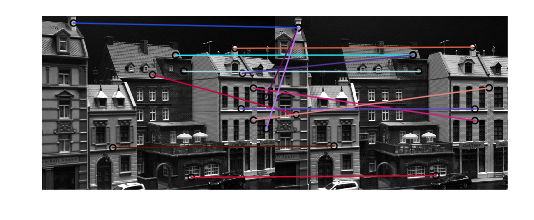

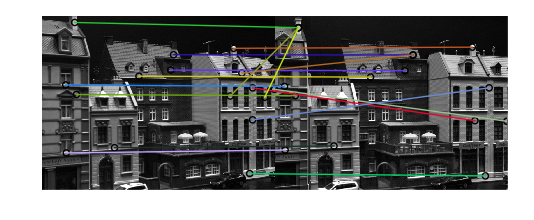

In [203]:
match(img1, feature_array1, img2, feature_array2, 0.8)
match(img2, feature_array2, img3, feature_array3, 0.9)
match(img1, feature_array1, img3, feature_array3, 0.9)